In [2]:
from collections import defaultdict, namedtuple, Counter
from itertools import combinations
import numpy as np
import scipy.stats
import sys
from os import listdir
import json
import random
import xgboost as xgb
import matplotlib.pyplot as plt
import graphviz
import csv
import sklearn
import cvxpy as cp
import mosek
import scipy.stats as stats

In [3]:
phase_dirs = ['../phased_spark_quads']
ped_files = ['../../DATA/spark/spark.ped.quads.ped']
identicals_files = ['../sibpair_similarity/spark_quads_identicals.txt']
out_dir = '../phased_spark_quads'

build = '38'
chroms = [str(x) for x in range(1, 23)]
#chroms = ['10']
interval = 500000

In [4]:
with open('../data/chrom_lengths%s.json' % build, 'r') as f:
	chrom_lengths = json.load(f)

In [5]:


def pull_phenotype_ped(ped_file):
	sample_to_sex = dict()
	sample_to_affected = dict()
	with open(ped_file, 'r') as f:
		for line in f:
			pieces = line.strip().split('\t')
			sample_to_sex[pieces[1]] = pieces[4]
			sample_to_affected[pieces[1]] = pieces[5]
	return sample_to_affected, sample_to_sex

Sibpair = namedtuple('Sibpair', ['family', 'sibling1', 'sibling2', 'mom', 'dad', 'phase_dir', 'num_affected', 'num_males'])
def pull_sibpairs(phase_dir, identicals_file, sample_to_affected, sample_to_sex):

	# pull identicals
	leave_out = set()
	with open(identicals_file, 'r') as f:
		for line in f:
			pieces = line.strip().split('\t')
			leave_out.update(pieces[1:])

	# pull individuals
	family_to_inds = defaultdict(list)
	sibpairs = list()
	for filename in listdir(phase_dir):
		if filename.endswith('.phased.txt'):
			family_key = filename[:-11]
			with open('%s/%s' % (phase_dir, filename), 'r')  as f:
				header = next(f).strip().split('\t')
				# check that we have a typical nuclear family structure
				if tuple(header[1:5]) == ('m1_del', 'm2_del', 'p1_del', 'p2_del'):
					individuals = [header[i][:-4] for i in range(5, len(header)-3, 2)]
					family_to_inds[family_key] = individuals
					for child1, child2 in combinations(individuals[2:], 2):
						if child1 not in leave_out and child2 not in leave_out and child1 in sample_to_affected and child2 in sample_to_affected:
							sibpairs.append(Sibpair(family_key, child1, child2, individuals[0], individuals[1], 
								phase_dir,
								int(sample_to_affected[child1]=='2')+int(sample_to_affected[child2]=='2'),
								int(sample_to_sex[child1]=='1')+int(sample_to_sex[child2]=='1')))

	sibpairs = sorted(sibpairs)

	assert len(sibpairs) == len(set(sibpairs)) # should have no duplicates
	return family_to_inds, sibpairs

def pull_sibpair_matches(phase_dirs, chrom, sibpairs, family_to_inds, interval_bins):
	sibpair_to_index = dict([((x.family, x.sibling1, x.sibling2), i) for i, x in enumerate(sibpairs)])

	# pull phase data
	# sibpair, interval, nomatch/match
	is_mat_match = -np.ones((len(sibpair_to_index), len(interval_bins)-1), dtype=int)
	is_pat_match = -np.ones((len(sibpair_to_index), len(interval_bins)-1), dtype=int)

	interval_lengths = interval_bins[1:]-interval_bins[:-1]

	for sibpair_index, sibpair in enumerate(sibpairs):
		mat_match_data = np.zeros((len(interval_bins)-1, 2), dtype=int)
		pat_match_data = np.zeros((len(interval_bins)-1, 2), dtype=int)
		with open('%s/%s.phased.txt' % (sibpair.phase_dir, sibpair.family), 'r')  as f:
			next(f) # skip header

			for line in f:
				pieces = line.strip().split('\t')
				if pieces[0][3:] == chrom:
					start_pos, end_pos = [int(x) for x in pieces[-2:]]
					state = np.array([int(x) for x in pieces[1:-2]])

					inds = family_to_inds[sibpair.family]
					sib1_ind_index, sib2_ind_index = inds.index(sibpair.sibling1), inds.index(sibpair.sibling2)
					sib1_mat_index, sib2_mat_index = 4+2*sib1_ind_index, 4+2*sib2_ind_index
					sib1_pat_index, sib2_pat_index = 5+2*sib1_ind_index, 5+2*sib2_ind_index

					start_index, end_index = np.searchsorted(interval_bins, [start_pos, end_pos])

					for index in range(start_index, end_index):
						overlap = min(interval_bins[index], end_pos) - max(interval_bins[index-1], start_pos)
						if (state[sib1_mat_index] != -1) and (state[sib2_mat_index] != -1):
							mat_match_data[index-1, int(state[sib1_mat_index]==state[sib2_mat_index])] += overlap

						if (state[sib1_pat_index] != -1) and (state[sib2_pat_index] != -1):
							pat_match_data[index-1, int(state[sib1_pat_index]==state[sib2_pat_index])] += overlap

		assert np.all(np.sum(mat_match_data, axis=1) <= interval_lengths)
		assert np.all(np.sum(pat_match_data, axis=1) <= interval_lengths)

		is_mat_match[sibpair_index, mat_match_data[:, 0]>=0.9*interval_lengths] = 0
		is_mat_match[sibpair_index, mat_match_data[:, 1]>=0.9*interval_lengths] = 1
		is_pat_match[sibpair_index, pat_match_data[:, 0]>=0.9*interval_lengths] = 0
		is_pat_match[sibpair_index, pat_match_data[:, 1]>=0.9*interval_lengths] = 1
				
	return is_mat_match, is_pat_match


In [6]:
# pull sample info
sample_to_affected, sample_to_sex = dict(), dict()
for ped_file in ped_files:
	aff, sex = pull_phenotype_ped(ped_file)
	sample_to_affected.update(aff)
	sample_to_sex.update(sex)

# pull sibpairs
family_to_inds, sibpairs = dict(), []
for phase_dir, identicals_file in zip(phase_dirs, identicals_files):
	print(phase_dir)
	faminds, sps = pull_sibpairs(phase_dir, identicals_file, sample_to_affected, sample_to_sex)
	duplicate_families = set()
	for famkey, inds in faminds.items():
		if famkey not in family_to_inds:
			family_to_inds[famkey] = inds
		else:
			duplicate_families.add(famkey)
	sibpairs.extend([x for x in sps if x.family not in duplicate_families])
	print('duplicates', len(duplicate_families))

print('Overall')
print('families', len(family_to_inds))
print('sibpairs', len(sibpairs))
print('num_affected', Counter([x.num_affected for x in sibpairs]))



../phased_spark_quads
duplicates 0
Overall
families 4166
sibpairs 3865
num_affected Counter({1: 3100, 2: 676, 0: 89})


In [57]:
print('num families', len(set([x.family.split('.')[0] for x in sibpairs])))

num families 3206


In [7]:
all_is_mat_match, all_is_pat_match = [], []
all_interval_bins = []
for chrom_index, chrom in enumerate(chroms):
    print(chrom)
    interval_bins = np.arange(0, chrom_lengths[chrom]+interval, interval)

    is_mat_match, is_pat_match = pull_sibpair_matches(phase_dirs, chrom, sibpairs, family_to_inds, interval_bins)
    all_is_mat_match.append(is_mat_match)
    all_is_pat_match.append(is_pat_match)
    all_interval_bins.append(np.vstack((chrom_index*np.ones((len(interval_bins)-1,)), interval_bins[:-1], interval_bins[1:])))
    
all_is_mat_match = np.hstack(all_is_mat_match)
all_is_pat_match = np.hstack(all_is_pat_match)
all_interval_bins = np.hstack(all_interval_bins).T

print(all_is_mat_match.shape, all_is_pat_match.shape, all_interval_bins.shape)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
(3865, 5760) (3865, 5760) (5760, 3)


In [9]:
label = np.array([x.num_affected for x in sibpairs])

In [52]:
lamb = 0.1*len(label)

mat_match = np.sum(all_is_mat_match==1, axis=0)
pat_match = np.sum(all_is_pat_match==1, axis=0)
mat_mismatch = np.sum(all_is_mat_match==0, axis=0)
pat_mismatch = np.sum(all_is_pat_match==0, axis=0)

p_mat = cp.Variable(all_is_mat_match.shape[1])
p_pat = cp.Variable(all_is_pat_match.shape[1])

# maximize likelihood
expr = mat_match@cp.log(p_mat) + mat_mismatch@cp.log(1-p_mat) + pat_match@cp.log(p_pat) + pat_mismatch@cp.log(1-p_pat)

# and regularize the difference between neighboring intervals (within each chromosome)
current_chrom = all_interval_bins[0][0]
current_chrom_start = 0
for i in range(1, len(all_interval_bins)):
	if all_interval_bins[i][0] != current_chrom:
		expr -= cp.tv(lamb*p_mat[current_chrom_start:i])
		expr -= cp.tv(lamb*p_pat[current_chrom_start:i])
		current_chrom, current_chrom_start = all_interval_bins[i][0], i
expr -= cp.tv(lamb*p_mat[current_chrom_start:i])
expr -= cp.tv(lamb*p_pat[current_chrom_start:i])
#expr -= lamb*cp.norm(p_mat-0.5, 1)
#expr -= lamb*cp.norm(p_pat-0.5, 1)
#expr -= lamb*cp.norm(p_mat-p_pat, 1)

# now solve
prob = cp.Problem(cp.Maximize(expr), [p_mat >= 0, p_mat <= 1,
									  p_pat >= 0, p_pat <= 1])
result = prob.solve(solver='MOSEK', mosek_params={'MSK_IPAR_INTPNT_MAX_ITERATIONS': 500}, verbose=True)
#result = prob.solve(solver='ECOS', max_iters=200, verbose=True)
print(prob.status)

if prob.status != 'optimal' and prob.status != 'optimal_inaccurate':
	raise Error('Parameters not fully estimated.')

p_mat = np.clip([v for v in p_mat.value], 0, 1) # clip just in case we have some numerical problems
p_pat = np.clip([v for v in p_pat.value], 0, 1) # clip just in case we have some numerical problems



Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 115108          
  Cones                  : 23040           
  Scalar variables       : 115154          
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 115108          
  Cones                  : 23040           
  Scalar variables       : 115154          
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer  - threads                : 8               
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 22994
Optimizer  - Cones                  : 23040
Optimizer  - Scalar var

In [53]:
print(np.sum(~np.isclose(p_mat[1:], p_mat[:-1])), len(p_mat))
print(np.sum(~np.isclose(p_pat[1:], p_pat[:-1])), len(p_pat))

978 5760
754 5760


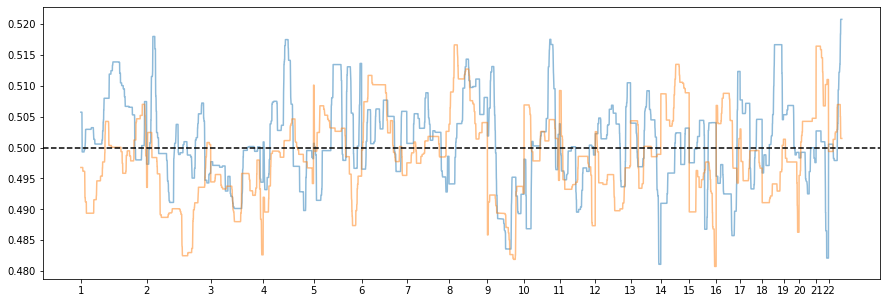

In [54]:
plt.figure(figsize=(15, 5))
plt.plot(p_mat[:-1], alpha=0.5)
plt.plot(p_pat[:-1], alpha=0.5)
plt.xticks([np.argmax(all_interval_bins[:, 0]==i) for i in range(len(chroms))], chroms)
plt.axhline(0.5, color='black', linestyle='--')
plt.show()

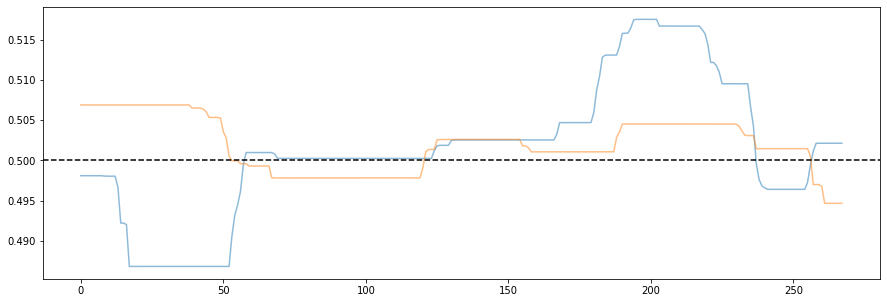

In [55]:
plt.figure(figsize=(15, 5))
plt.plot(p_mat[all_interval_bins[:, 0]==9], alpha=0.5)
plt.plot(p_pat[all_interval_bins[:, 0]==9], alpha=0.5)
#plt.xticks([np.argmax(all_interval_bins[:, 0]==i) for i in range(len(chroms))], chroms)
plt.axhline(0.5, color='black', linestyle='--')
plt.show()

In [50]:
colors=plt.rcParams['axes.prop_cycle'].by_key()['color']

(0.5009172732617084, 0.004433249621246242)
(0.49853666565759214, 0.005835538972465286)
0.5 0.008042577512222279


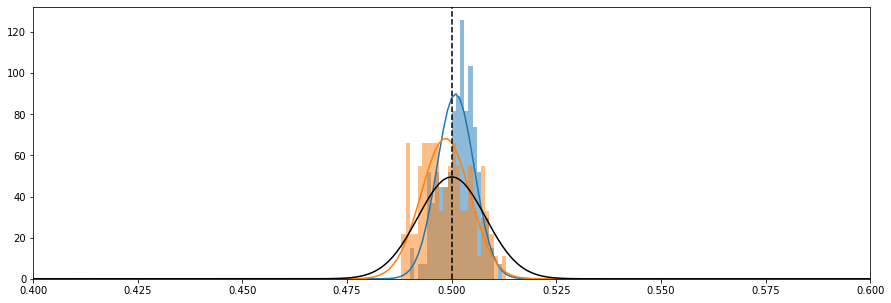

In [51]:
mat_indices = np.where(~np.isclose(p_mat[1:], p_mat[:-1]))[0]
pat_indices = np.where(~np.isclose(p_pat[1:], p_pat[:-1]))[0]

plt.figure(figsize=(15, 5))
plt.hist(p_mat[mat_indices], alpha=0.5, bins=np.arange(0, 1, 0.001), density=True)
plt.hist(p_pat[pat_indices], alpha=0.5, bins=np.arange(0, 1, 0.001), density=True)

mat_params = stats.norm.fit(p_mat)
print(mat_params)
plt.plot(np.arange(0, 1, 0.001), stats.norm.pdf(np.arange(0, 1, 0.001), *mat_params), color=colors[0])
pat_params = stats.norm.fit(p_pat)
print(pat_params)
plt.plot(np.arange(0, 1, 0.001), stats.norm.pdf(np.arange(0, 1, 0.001), *pat_params), color=colors[1])
print(0.5, np.sqrt(0.5*0.5/all_is_mat_match.shape[0]))
plt.plot(np.arange(0, 1, 0.001), stats.norm.pdf(np.arange(0, 1, 0.001), loc=0.5, scale=np.sqrt(0.5*0.5/all_is_mat_match.shape[0])), color='black')

plt.axvline(0.5, color='black', linestyle='--')
plt.xlim([0.4, 0.6])
plt.show()


In [16]:
print(stats.norm.isf(0.05/np.sum(mat_indices), *mat_params))
#print(np.sum(p_mat>))

0.7701291803229524


In [17]:
print(np.sum(p_mat[mat_indices]>stats.norm.isf(0.05/np.sum(mat_indices), *mat_params)))
print(np.sum(p_pat[pat_indices]>stats.norm.isf(0.05/np.sum(pat_indices), *pat_params)))

0
0


In [ ]:
print(is_mat_match)

In [ ]:
lamb = 1*len(label)

mat_match = np.sum(all_is_mat_match[label==0, :]==1, axis=0)
pat_match = np.sum(all_is_pat_match[label==0, :]==1, axis=0)
mat_mismatch = np.sum(all_is_mat_match[label==0, :]==0, axis=0)
pat_mismatch = np.sum(all_is_pat_match[label==0, :]==0, axis=0)

p_mat = cp.Variable(all_is_mat_match.shape[1])
p_pat = cp.Variable(all_is_pat_match.shape[1])

y = (label==1).astype(int)

# maximize likelihood
expr = cp.sum( cp.multiply(y, (all_is_mat_match @ p_mat) + (all_is_pat_match @ p_pat)) - cp.logistic((all_is_mat_match @ p_mat) + (all_is_pat_match @ p_pat)))
# and regularize the difference between neighboring intervals (within each chromosome)
current_chrom = all_interval_bins[0][0]
current_chrom_start = 0
for i in range(1, len(all_interval_bins)):
	if all_interval_bins[i][0] != current_chrom:
		expr -= cp.tv(lamb*p_mat[current_chrom_start:i])
		expr -= cp.tv(lamb*p_pat[current_chrom_start:i])
		current_chrom, current_chrom_start = all_interval_bins[i][0], i
expr -= cp.tv(lamb*p_mat[current_chrom_start:i])
expr -= cp.tv(lamb*p_pat[current_chrom_start:i])
#expr -= lamb*cp.norm(p_mat-0.5, 1)
#expr -= lamb*cp.norm(p_pat-0.5, 1)
#expr -= lamb*cp.norm(p_mat-p_pat, 1)

# now solve
prob = cp.Problem(cp.Maximize(expr))
result = prob.solve(solver='MOSEK', mosek_params={'MSK_IPAR_INTPNT_MAX_ITERATIONS': 500}, verbose=True)
#result = prob.solve(solver='ECOS', max_iters=200, verbose=True)
print(prob.status)

if prob.status != 'optimal' and prob.status != 'optimal_inaccurate':
	raise Error('Parameters not fully estimated.')

p_mat = np.array([v for v in p_mat.value])
p_pat = np.array([v for v in p_pat.value])